🚀 TP TRM-VISION – Fashion-MNIST Kaggle (TRM small++ + classifier)
Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\zalando-research\fashionmnist\versions\4
✅ Fashion-MNIST Kaggle: x_train=(60000, 16, 16), y_train=(60000,)

🔧 Entraînement TRM small++ (Fashion-MNIST, 20 époques)...
Epoch 1/20
33/33 [==============================] - 75s 2s/step - loss: 0.8042 - val_loss: 0.7074
Epoch 2/20
33/33 [==============================] - 60s 2s/step - loss: 0.6466 - val_loss: 0.6431
Epoch 3/20
33/33 [==============================] - 63s 2s/step - loss: 0.5872 - val_loss: 0.5841
Epoch 4/20
33/33 [==============================] - 67s 2s/step - loss: 0.5413 - val_loss: 0.5325
Epoch 5/20
33/33 [==============================] - 73s 2s/step - loss: 0.4992 - val_loss: 0.5131
Epoch 6/20
33/33 [==============================] - 92s 3s/step - loss: 0.3246 - val_loss: 0.2291
Epoch 7/20
33/33 [==============================] - 73s 2s/step - loss: 0.2114 - val_loss: 0.1921
Epoch 8/20
33/33 [=

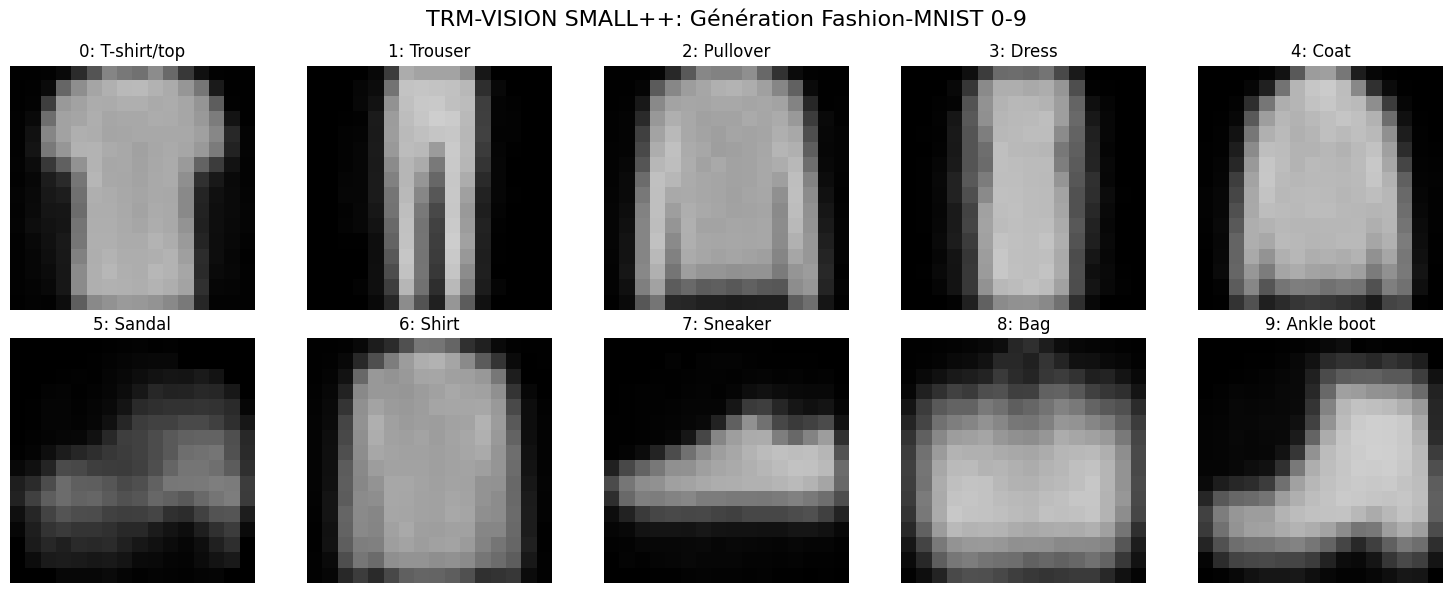

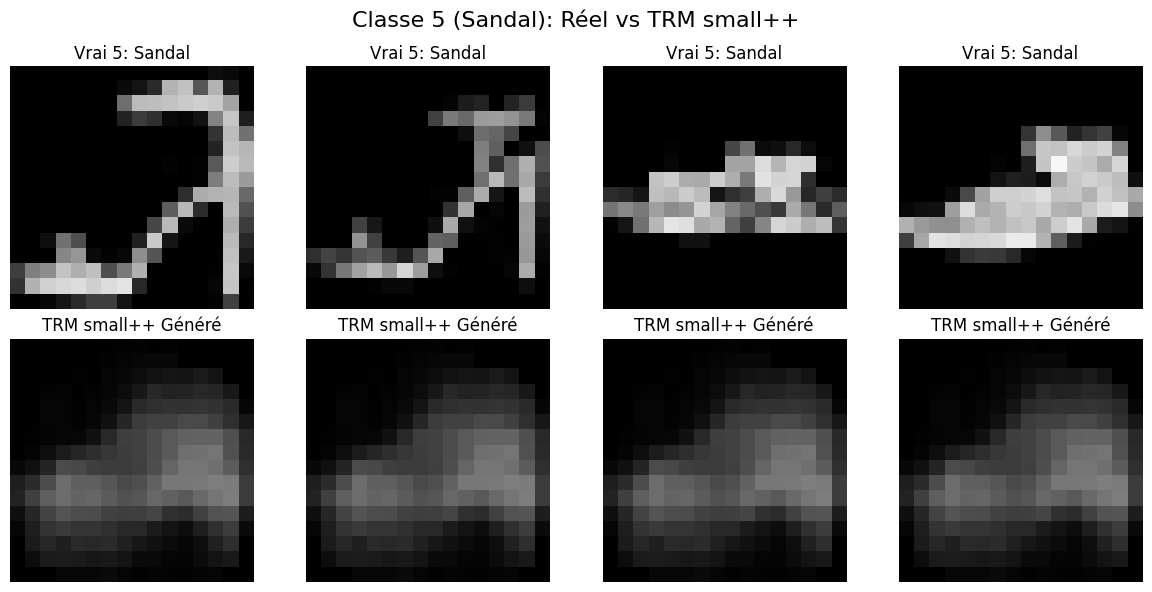

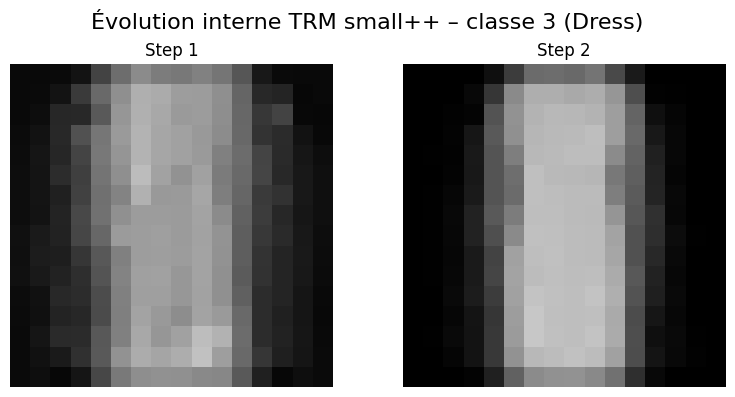


🎉 Résumé TP TRM-VISION – Fashion-MNIST Kaggle (TRM small++)
   → TRM small++: d=32, n_rec=2, loss fin:  0.1781
   → CNN val accuracy: 86.74%
   → Reconnaissance CNN sur images Fashion-MNIST TRM small++: 89.30%
   → Figures: grille 0-9 (vêtements), vrai vs généré, trajectoire interne


In [33]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import kagglehub

print("🚀 TP TRM-VISION – Fashion-MNIST Kaggle (TRM small++ + classifier)")

# =============================================================================
# 0. Download Kaggle Fashion-MNIST
# =============================================================================
path = kagglehub.dataset_download("zalando-research/fashionmnist")
print("Path to dataset files:", path)

train_csv = os.path.join(path, "fashion-mnist_train.csv")
test_csv  = os.path.join(path, "fashion-mnist_test.csv")

# =============================================================================
# 1. TinyBlock
# =============================================================================
class TinyBlock(layers.Layer):
    def __init__(self, d):
        super().__init__()
        self.ln = layers.LayerNormalization()
        self.fc1 = layers.Dense(4 * d, activation="gelu")
        self.fc2 = layers.Dense(d)

    def call(self, u):
        h = self.ln(u)
        h = self.fc1(h)
        h = self.fc2(h)
        return u + h

# =============================================================================
# 2. TRM-VISION (version un peu plus large)
# =============================================================================
class TRM_VISION(keras.Model):
    def __init__(self, img_size=16, d=32, n_rec=2, name_suffix="smallpp"):
        super().__init__(name=f"TRM_VISION_{name_suffix}")
        self.img_size = img_size
        self.d = d
        self.n_rec = n_rec
        
        self.cond_emb = layers.Embedding(10, d)
        self.y0 = self.add_weight(
            shape=(1, img_size*img_size, d),
            initializer="zeros",
            trainable=True,
            name=f"y0_{name_suffix}"
        )
        self.z0 = self.add_weight(
            shape=(1, img_size*img_size, d),
            initializer="zeros",
            trainable=True,
            name=f"z0_{name_suffix}"
        )
        self.block1 = TinyBlock(d)
        self.block2 = TinyBlock(d)
        self.to_pixels = layers.Dense(1)

    def call(self, class_tokens, target_img=None, return_intermediate=False):
        B = tf.shape(class_tokens)[0]
        L = self.img_size * self.img_size
        
        c = self.cond_emb(class_tokens)              # [B, d]
        c = tf.tile(tf.expand_dims(c, 1), [1, L, 1]) # [B, L, d]
        
        y = tf.tile(self.y0, [B, 1, 1])
        z = tf.tile(self.z0, [B, 1, 1])
        
        inter_imgs = []

        for _ in range(self.n_rec):
            z = self.block2(self.block1(c + y + z))
            y = self.block2(self.block1(y + z))
            if return_intermediate:
                pixels_step = self.to_pixels(y)
                img_step = tf.tanh(tf.reshape(pixels_step, [B, self.img_size, self.img_size, 1]))
                inter_imgs.append(img_step)

        pixels = self.to_pixels(y)
        img = tf.tanh(tf.reshape(pixels, [B, self.img_size, self.img_size, 1]))
        if return_intermediate and len(inter_imgs) == 0:
            inter_imgs.append(img)

        loss = None
        if target_img is not None:
            loss = tf.reduce_mean(tf.keras.losses.mse(target_img, img))

        if return_intermediate:
            return img, loss, inter_imgs
        if loss is None:
            return img
        return img, loss

# =============================================================================
# 3. Dataset Kaggle Fashion-MNIST → 16x16
# =============================================================================
def load_fashion_mnist_csv(csv_path):
    df = pd.read_csv(csv_path)
    labels = df['label'].values.astype(np.int64)
    pixels = df.drop(columns=['label']).values.astype(np.float32)
    images = pixels.reshape(-1, 28, 28)
    return images, labels

x_train_full, y_train = load_fashion_mnist_csv(train_csv)
x_test_full,  y_test  = load_fashion_mnist_csv(test_csv)

x_train_full = x_train_full / 127.5 - 1.0
x_test_full  = x_test_full  / 127.5 - 1.0

x_train = np.squeeze(tf.image.resize(tf.expand_dims(x_train_full, -1), [16, 16]).numpy())
x_test  = np.squeeze(tf.image.resize(tf.expand_dims(x_test_full,  -1), [16, 16]).numpy())

print(f"✅ Fashion-MNIST Kaggle: x_train={x_train.shape}, y_train={y_train.shape}")

# Plus de données pour le CNN, sous-ensemble plus petit pour le TRM
train_idx_trm = 10000   # TRM rapide (~32 steps/epoch)
val_idx_trm   = 2000

train_idx_cnn = 20000   # CNN peut garder plus de données
val_idx_cnn   = 5000

# Pour TRM
x_train_small_trm = x_train[:train_idx_trm]
y_train_small_trm = y_train[:train_idx_trm]
x_val_small_trm   = x_test[:val_idx_trm]
y_val_small_trm   = y_test[:val_idx_trm]

# Pour CNN (comme avant)
x_train_small = x_train[:train_idx_cnn]
y_train_small = y_train[:train_idx_cnn]
x_val_small   = x_test[:val_idx_cnn]
y_val_small   = y_test[:val_idx_cnn]

# =============================================================================
# 4. TRM small++ (entraîner plus longtemps MAIS plus rapide)
# =============================================================================
trm_small = TRM_VISION(img_size=16, d=32, n_rec=2, name_suffix="smallpp")
trm_small.compile(optimizer='adam', loss='mse')

# batch_size pour ≈32 steps/epoch
batch_size_trm = train_idx_trm // 32  # ~312

print("\n🔧 Entraînement TRM small++ (Fashion-MNIST, 20 époques)...")
hist_small = trm_small.fit(
    y_train_small_trm, x_train_small_trm,
    epochs=20,
    batch_size=batch_size_trm,
    verbose=1,
    validation_data=(y_val_small_trm, x_val_small_trm)
)

# =============================================================================
# 5. CNN classifier Fashion-MNIST 16x16 (plus de données + plus d’époques)
# =============================================================================
print("\n🔧 Entraînement CNN classifier Fashion-MNIST (16x16, 20 époques)...")

cnn = keras.Sequential([
    layers.Input(shape=(16, 16, 1)),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPool2D(2),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

cnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn.fit(
    x_train_small[..., np.newaxis], y_train_small,
    epochs=20,
    batch_size=256,
    verbose=1,
    validation_data=(x_val_small[..., np.newaxis], y_val_small)
)

# =============================================================================
# 6. Évaluation: taux de reconnaissance des images générées
# =============================================================================
def eval_trm_with_cnn(trm_model, name, n_samples=1000):
    labels = np.random.randint(0, 10, size=(n_samples,))
    gen_imgs = trm_model(tf.constant(labels)).numpy()
    preds = cnn.predict(gen_imgs, verbose=0)
    pred_labels = preds.argmax(axis=1)
    acc = (pred_labels == labels).mean()
    print(f"📊 Taux de reconnaissance CNN sur images Fashion-MNIST générées ({name}): {acc*100:.2f}%")
    return acc, gen_imgs, labels

acc_small, gen_small_imgs, gen_small_labels = eval_trm_with_cnn(trm_small, "TRM small++")

# =============================================================================
# 7. Grille de génération 0-9 (vêtements)
# =============================================================================
class_names = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

def plot_grid(trm_model, title):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(10):
        # Génération avec le modèle
        gen_imgs = trm_model(tf.constant([i]), training=False)
        # Conversion tensor → numpy si nécessaire
        if isinstance(gen_imgs, tf.Tensor):
            gen_imgs = gen_imgs.numpy()
        img_data = gen_imgs[0, :, :, 0]
        
        # Debug pour la première image
        if i == 0:
            print(f"Debug classe {i}: shape={img_data.shape}, min={img_data.min():.3f}, max={img_data.max():.3f}, mean={img_data.mean():.3f}")
        
        # Affichage avec normalisation automatique si toutes les valeurs sont identiques
        if img_data.min() == img_data.max():
            print(f"⚠️ Attention: classe {i} a toutes les valeurs identiques ({img_data.min():.3f})")
            # Afficher quand même avec une échelle par défaut
            axes[i//5, i%5].imshow(img_data, cmap='gray')
        else:
            axes[i//5, i%5].imshow(img_data, cmap='gray', vmin=-1, vmax=1)
        
        axes[i//5, i%5].set_title(f"{i}: {class_names[i]}")
        axes[i//5, i%5].axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_grid(trm_small, "TRM-VISION SMALL++: Génération Fashion-MNIST 0-9")

# =============================================================================
# 8. Target vs généré pour une classe (ex: 5 = Sandal)
# =============================================================================
def plot_target_vs_gen(model, x_test_arr, y_test_arr, digit=5, title_prefix="TRM"):
    idx = np.where(y_test_arr == digit)[0][:4]
    target = x_test_arr[idx]
    gen = model(tf.constant([digit]*4)).numpy()
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(4):
        axes[0,i].imshow(target[i], cmap='gray', vmin=-1, vmax=1)
        axes[0,i].set_title(f"Vrai {digit}: {class_names[digit]}")
        axes[0,i].axis('off')
        axes[1,i].imshow(gen[i, :, :, 0], cmap='gray', vmin=-1, vmax=1)
        axes[1,i].set_title(f"{title_prefix} Généré")
        axes[1,i].axis('off')
    plt.suptitle(f"Classe {digit} ({class_names[digit]}): Réel vs {title_prefix}", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_target_vs_gen(trm_small, x_test, y_test, digit=5, title_prefix="TRM small++")

# =============================================================================
# 9. Visualisation trajectoire interne (TRM small++)
# =============================================================================
digit_demo = 3  # Dress
_, _, inter_imgs = trm_small(tf.constant([digit_demo]), return_intermediate=True)

fig, axes = plt.subplots(1, len(inter_imgs), figsize=(4*len(inter_imgs), 4))
if len(inter_imgs) == 1:
    axes = [axes]

for i, img_t in enumerate(inter_imgs):
    axes[i].imshow(img_t[0, :, :, 0].numpy(), cmap='gray', vmin=-1, vmax=1)
    axes[i].set_title(f"Step {i+1}")
    axes[i].axis('off')
plt.suptitle(f"Évolution interne TRM small++ – classe {digit_demo} ({class_names[digit_demo]})", fontsize=16)
plt.tight_layout()
plt.show()

# =============================================================================
# 10. Récapitulatif console
# =============================================================================
val_acc_cnn = cnn.evaluate(x_val_small[...,np.newaxis], y_val_small, verbose=0)[1]*100
print("\n" + "="*70)
print("🎉 Résumé TP TRM-VISION – Fashion-MNIST Kaggle (TRM small++)")
print(f"   → TRM small++: d={trm_small.d}, n_rec={trm_small.n_rec}, loss fin:  {hist_small.history['loss'][-1]:.4f}")
print(f"   → CNN val accuracy: {val_acc_cnn:.2f}%")
print(f"   → Reconnaissance CNN sur images Fashion-MNIST TRM small++: {acc_small*100:.2f}%")
print("   → Figures: grille 0-9 (vêtements), vrai vs généré, trajectoire interne")
print("="*70)


In [34]:
# =============================================================================
# 11. Démo utilisateur : prédire la classe d'une image de vêtement
# =============================================================================
from PIL import Image

def preprocess_user_image(img_path):
    """
    Charge une image utilisateur, la convertit en 28x28 niveaux de gris
    et la normalise dans [-1, 1] comme Fashion-MNIST.
    """
    img = Image.open(img_path).convert("L")  # Niveaux de gris
    img = img.resize((16, 16))              # Même taille que le modèle
    img_np = np.array(img).astype(np.float32)
    img_np = img_np / 127.5 - 1.0           # Normalisation [-1,1]
    return img_np

def predict_user_image(img_path):
    img_np = preprocess_user_image(img_path)
    x = img_np[np.newaxis, ..., np.newaxis]  # [1,16,16,1]
    preds = cnn.predict(x, verbose=0)
    pred_class = int(np.argmax(preds[0]))
    prob = float(np.max(preds[0]))
    
    plt.figure(figsize=(3,3))
    plt.imshow(img_np, cmap="gray", vmin=-1, vmax=1)
    plt.title(f"Prédiction: {pred_class} – {class_names[pred_class]} ({prob*100:.1f} %)")
    plt.axis("off")
    plt.show()
    
    return pred_class, prob

# Exemple d'utilisation :
# 1) mets une image dans ton dossier, par ex. "mon_tshirt.png" ou "shoe.jpg"
# 2) appelle:
# pred_class, prob = predict_user_image("mon_image_vetement.png")


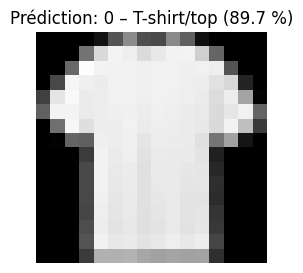

In [35]:
pred_class, prob = predict_user_image("1.png")  

In [36]:
# =============================================================================
# 12. Démo complète : image utilisateur → classe CNN → image TRM générée
# =============================================================================

def user_demo_with_trm(img_path):
    """
    1) Charge une image utilisateur.
    2) La passe dans le CNN pour prédire la classe de vêtement.
    3) Génère une image 'prototype' avec TRM pour la classe prédite.
    4) Affiche les deux côte à côte.
    """
    # Prétraitement identique à predict_user_image
    img = Image.open(img_path).convert("L")
    img = img.resize((16, 16))
    img_np = np.array(img).astype(np.float32)
    img_np_norm = img_np / 127.5 - 1.0

    x = img_np_norm[np.newaxis, ..., np.newaxis]  # [1,16,16,1]
    preds = cnn.predict(x, verbose=0)
    pred_class = int(np.argmax(preds[0]))
    prob = float(np.max(preds[0]))

    # Génération TRM à partir de la classe prédite
    gen_img = trm_small(tf.constant([pred_class])).numpy()[0, :, :, 0]

    # Affichage côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    axes[0].imshow(img_np_norm, cmap="gray", vmin=-1, vmax=1)
    axes[0].set_title(f"Image utilisateur\nPrédiction: {pred_class} – {class_names[pred_class]}\n({prob*100:.1f} %)")
    axes[0].axis("off")
    
    axes[1].imshow(gen_img, cmap="gray", vmin=-1, vmax=1)
    axes[1].set_title(f"Prototype TRM\nClasse {pred_class} – {class_names[pred_class]}")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    return pred_class, prob

# Exemple d'utilisation :
# user_demo_with_trm("mon_image_vetement.png")


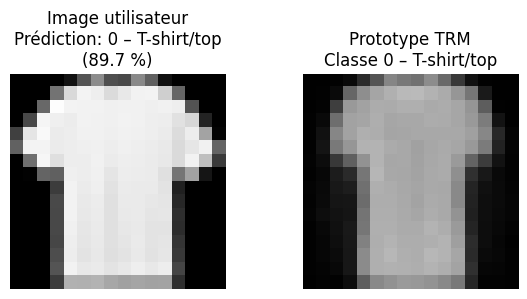

(0, 0.8966465592384338)

In [37]:
user_demo_with_trm("1.png")  

In [38]:
# =============================================================================
# 13. Orchestrateur multimodal Fashion-TRM
# =============================================================================

class FashionMultimodalOrchestrator:
    """Orchestrateur multimodal pour le TP TRM‑VISION Fashion‑MNIST.

    Combine plusieurs modalités / signaux :
      - l'image (via le CNN de classification),
      - un contexte texte court (description de style / usage),
      - un réglage numérique de "créativité".

    L'orchestrateur agrège ces informations pour choisir une classe finale
    de vêtement et piloter le TRM générateur d'images.
    """

    def __init__(self, trm_model, cnn_model, class_names):
        self.trm_model = trm_model
        self.cnn_model = cnn_model
        self.class_names = class_names

        # Petit dictionnaire heuristique qui relie des mots-clés de style
        # à des classes Fashion‑MNIST préférées (logique métier, non apprise).
        self.style_keywords = {
            "sport": ["Sneaker", "T-shirt/top"],
            "décontracté": ["T-shirt/top", "Sneaker", "Sandal"],
            "casual": ["T-shirt/top", "Sneaker", "Sandal"],
            "élégant": ["Dress", "Coat", "Ankle boot"],
            "professionnel": ["Coat", "Bag", "Shirt"],
            "soirée": ["Dress", "Ankle boot", "Sandal"],
        }

    # ------------------------------------------------------------------
    # Encodage très simple du texte de style en pondérations de classes
    # ------------------------------------------------------------------
    def encode_style_preferences(self, text):
        """Transforme un texte de style en pondérations par classe.

        Retourne un vecteur de taille 10 (une pondération par classe
        Fashion‑MNIST). Plus la pondération est élevée, plus la classe
        est "compatible" avec le style demandé.
        """
        num_classes = len(self.class_names)
        weights = np.ones(num_classes, dtype=np.float32)

        if text is None:
            return weights

        t = text.lower().strip()
        if not t:
            return weights

        for word, preferred_classes in self.style_keywords.items():
            if word in t:
                for cname in preferred_classes:
                    if cname in self.class_names:
                        idx = self.class_names.index(cname)
                        weights[idx] += 3.0  # boost heuristique plus fort pour voir l'effet

        return weights

    # ------------------------------------------------------------------
    # Analyse multimodale principale
    # ------------------------------------------------------------------
    def analyze(self, img_pil, style_text="", creativity=0.5):
        """Analyse multimodale et génération d'un prototype TRM.

        Args:
            img_pil: image utilisateur (PIL.Image), couleurs ou N&B
            style_text: description texte courte ("sport", "soirée", ...)
            creativity: float dans [0,1] qui pèse l'influence du texte
                         vs la prédiction pure du CNN.

        Returns:
            dict contenant les infos d'analyse + tensors d'images normalisées.
        """
        # 1) Prétraitement identique au reste du TP
        img_gray = img_pil.convert("L")
        img_gray = img_gray.resize((16, 16))
        img_np = np.array(img_gray).astype(np.float32)
        img_np_norm = img_np / 127.5 - 1.0

        x = img_np_norm[np.newaxis, ..., np.newaxis]  # [1,16,16,1]

        # 2) Prédiction brute du CNN (vision seule)
        preds = self.cnn_model.predict(x, verbose=0)[0]  # (10,)

        # 3) Encodage texte → préférences de classes
        style_weights = self.encode_style_preferences(style_text)

        # 4) Fusion améliorée vision + texte contrôlée par "creativity"
        alpha = float(np.clip(creativity, 0.0, 1.0))

        # Normaliser les style_weights pour en faire une distribution de probabilité
        # (même si le texte ne correspond à rien, on garde une distribution uniforme)
        style_distribution = style_weights / style_weights.sum()

        # Fusion pondérée : mélange entre prédiction CNN et préférences texte
        # Plus alpha est élevé, plus on fait confiance au texte
        fused_scores = (1.0 - alpha) * preds + alpha * style_distribution
        
        # Normalisation finale pour garantir une distribution de probabilité
        fused_scores = fused_scores / fused_scores.sum()
        
        # Si le texte est vide ou alpha=0, on devrait avoir exactement preds
        # (vérification de cohérence)

        base_class = int(np.argmax(preds))
        final_class = int(np.argmax(fused_scores))

        # 5) Génération TRM conditionnée par la classe finale
        gen_img = self.trm_model(tf.constant([final_class])).numpy()[0, :, :, 0]

        summary = {
            "cnn_top_class": base_class,
            "cnn_top_label": self.class_names[base_class],
            "final_class": final_class,
            "final_label": self.class_names[final_class],
            "creativity": float(alpha),
            "style_text": style_text or "",
        }

        return {
            "img_np_norm": img_np_norm,
            "gen_img": gen_img,
            "preds": preds,
            "fused_scores": fused_scores,
            "summary": summary,
        }


# Instanciation globale de l'orchestrateur avec les modèles déjà entraînés
fashion_orchestrator = FashionMultimodalOrchestrator(
    trm_model=trm_small,
    cnn_model=cnn,
    class_names=class_names,
)


In [43]:
# =============================================================================
# 14. Interface web Gradio – TRM multimodal + orchestrateur
# =============================================================================

import gradio as gr


def trm_multimodal_demo(img, style_text, creativity):
    """Pipeline complète utilisée par Gradio, pilotée par l'orchestrateur.

    1) Image utilisateur → CNN (vision)
    2) Texte court + curseur de créativité → préférences de style
    3) Orchestrateur fusionne tout et choisit une classe finale
    4) TRM génère un prototype conditionné par cette classe
    """
    if img is None:
        return "Aucune image fournie.", None, None

    result = fashion_orchestrator.analyze(
        img_pil=img,
        style_text=style_text or "",
        creativity=float(creativity or 0.0),
    )

    img_np_norm = result["img_np_norm"]
    gen_img = result["gen_img"]
    summary = result["summary"]
    preds = result["preds"]
    fused_scores = result["fused_scores"]

    # Remise en [0, 255] pour affichage propre
    user_vis = ((img_np_norm + 1.0) * 127.5).clip(0, 255).astype(np.uint8)
    gen_vis = ((gen_img + 1.0) * 127.5).clip(0, 255).astype(np.uint8)

    user_pil = Image.fromarray(user_vis, mode="L")
    gen_pil = Image.fromarray(gen_vis, mode="L")

    # Affichage détaillé avec top 3 classes CNN et fusionnées
    top3_cnn = np.argsort(preds)[-3:][::-1]
    top3_fused = np.argsort(fused_scores)[-3:][::-1]
    
    label_text = "=" * 50 + "\n"
    label_text += "📊 ANALYSE MULTIMODALE\n"
    label_text += "=" * 50 + "\n\n"
    
    label_text += "🎯 CNN (vision seule) - Top 3 :\n"
    for i, idx in enumerate(top3_cnn):
        prob = preds[idx] * 100
        marker = "👑" if idx == summary['cnn_top_class'] else "  "
        label_text += f"{marker} {idx}. {class_names[idx]:20s} : {prob:5.1f}%\n"
    
    label_text += "\n"
    label_text += f"✨ Créativité (poids texte) : {summary['creativity']:.2f}\n"
    if summary["style_text"]:
        label_text += f"📝 Contexte texte : \"{summary['style_text']}\"\n"
    
    label_text += "\n"
    label_text += "🎨 Décision finale (fusion vision + texte) - Top 3 :\n"
    for i, idx in enumerate(top3_fused):
        score = fused_scores[idx] * 100
        marker = "👑" if idx == summary['final_class'] else "  "
        label_text += f"{marker} {idx}. {class_names[idx]:20s} : {score:5.1f}%\n"
    
    label_text += "\n"
    if summary['cnn_top_class'] != summary['final_class']:
        label_text += "🔄 CHANGEMENT DÉTECTÉ ! Le texte a modifié la décision.\n"
        label_text += f"   CNN seul → {summary['cnn_top_label']}\n"
        label_text += f"   Multimodal → {summary['final_label']}\n"
    else:
        label_text += "✓ Décision cohérente : vision et texte convergent.\n"
        label_text += f"   Classe finale : {summary['final_label']}\n"

    return label_text, user_pil, gen_pil


custom_css = """
body {
    background: radial-gradient(circle at top, #0f172a 0, #020617 55%, #000 100%);
}
.main-container {
    max-width: 1100px;
    margin: 0 auto;
}
.gradio-container {
    background: transparent !important;
}
footer, .dark .footer, .svelte-1ipelgc { /* cache "Créé avec Gradio" etc. */
    display: none !important;
}
#trm-header {
    background: linear-gradient(135deg, rgba(56,189,248,0.12), rgba(129,140,248,0.08));
    border-radius: 18px;
    border: 1px solid rgba(148,163,184,0.4);
    padding: 18px 22px;
    margin-bottom: 18px;
    box-shadow: 0 18px 45px rgba(15,23,42,0.9);
}
#trm-header h1 {
    font-size: 1.5rem;
    font-weight: 700;
    letter-spacing: .03em;
    margin-bottom: 6px;
}
#trm-header p {
    color: #cbd5f5;
    margin: 0;
}
#trm-card {
    background: rgba(15,23,42,0.9);
    border-radius: 18px;
    border: 1px solid rgba(148,163,184,0.5);
    padding: 18px 20px;
    box-shadow: 0 20px 40px rgba(15,23,42,0.9);
}
#trm-card h2 {
    font-size: 1.1rem;
    font-weight: 600;
    margin-bottom: 4px;
}
#trm-card p {
    font-size: .9rem;
    color: #9ca3af;
}
/* Agrandir la zone "Analyse multimodale" */
textarea[data-testid*="Analyse multimodale"], 
.gr-textbox textarea {
    min-height: 300px !important;
    font-family: 'Courier New', monospace !important;
    font-size: 0.9rem !important;
    line-height: 1.5 !important;
}
/* Agrandir les zones d'images */
.gr-image img,
.gr-image canvas,
.gr-image > div {
    min-height: 300px !important;
    width: 100% !important;
    object-fit: contain !important;
}
.gr-image {
    min-height: 350px !important;
}
"""

with gr.Blocks(css=custom_css, theme=gr.themes.Soft(primary_hue="indigo")) as demo:
    with gr.Column(elem_id="trm-page", elem_classes=["main-container"]):
        with gr.Row(elem_id="trm-header"):
            with gr.Column(scale=3):
                gr.Markdown("""<h1>TRM‑VISION · Fashion‑MNIST (multimodal)</h1>
<p><b>Orchestrateur multimodal</b> : combine vision (CNN) + texte (style) + créativité pour piloter le TRM génératif.<br>
💡 <b>Astuce</b> : Pour voir l'effet du texte, utilise un style différent de la prédiction CNN (ex: si CNN prédit "T-shirt", essayez "élégant" ou "soirée").</p>""")
        with gr.Row(elem_id="trm-card"):
            with gr.Column(scale=4):
                input_img = gr.Image(
                    type="pil",
                    label="Image de vêtement (upload ou webcam)",
                    sources=["upload", "webcam"],
                )
                style_text = gr.Textbox(
                    label="Contexte texte (style souhaité)",
                    placeholder="Exemples: 'sport', 'élégant', 'soirée', 'professionnel', 'décontracté'...",
                    value="",
                )
                creativity = gr.Slider(
                    minimum=0.0,
                    maximum=1.0,
                    step=0.1,
                    value=0.3,
                    label="Créativité (poids du texte vs vision)",
                )
                analyze_btn = gr.Button("Analyser la tenue", variant="primary")
                pred_text = gr.Textbox(
                    label="Analyse multimodale", 
                    interactive=False,
                    lines=15,
                    max_lines=20
                )
            with gr.Column(scale=5):
                with gr.Row():
                    user_img = gr.Image(
                        label="Image utilisateur (prétraitée)",
                        height=350
                    )
                    gen_img = gr.Image(
                        label="Prototype généré par TRM",
                        height=350
                    )
        analyze_btn.click(
            trm_multimodal_demo,
            inputs=[input_img, style_text, creativity],
            outputs=[pred_text, user_img, gen_img],
        )

# Lance l'interface dans le navigateur (onglet local). Pour le partage public : demo.launch(share=True)
demo.launch(inbrowser=True)


C:\Users\User\AppData\Local\Temp\ipykernel_17852\3283047285.py:145: UserWarning: The parameters have been moved from the Blocks constructor to the launch() method in Gradio 6.0: theme, css. Please pass these parameters to launch() instead.
  with gr.Blocks(css=custom_css, theme=gr.themes.Soft(primary_hue="indigo")) as demo:


* Running on local URL:  http://127.0.0.1:7870
* To create a public link, set `share=True` in `launch()`.


In [40]:
# =============================================================================
# 15. Sauvegarde des résultats d'analyse multimodale
# =============================================================================

import json
from datetime import datetime
from PIL import Image

def save_multimodal_results(result_dict, output_dir="results_trm"):
    """
    Sauvegarde les résultats d'une analyse multimodale dans un dossier.
    
    Args:
        result_dict: dictionnaire retourné par fashion_orchestrator.analyze()
        output_dir: dossier de sortie (créé s'il n'existe pas)
    """
    os.makedirs(output_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    summary = result_dict["summary"]
    
    # 1. Sauvegarde du texte d'analyse
    analysis_text = f"""==================================================
📊 ANALYSE MULTIMODALE
==================================================

🎯 CNN (vision seule) - Top 3 :
👑 {summary['cnn_top_class']}. {summary['cnn_top_label']} : {result_dict['preds'][summary['cnn_top_class']]*100:.1f}%

✨ Créativité (poids texte) : {summary['creativity']:.2f}
📝 Contexte texte : "{summary['style_text']}"

🎨 Décision finale (fusion vision + texte) :
👑 {summary['final_class']}. {summary['final_label']}

"""
    
    if summary['cnn_top_class'] != summary['final_class']:
        analysis_text += f"""
🔄 CHANGEMENT DÉTECTÉ ! Le texte a modifié la décision.
   CNN seul → {summary['cnn_top_label']}
   Multimodal → {summary['final_label']}
"""
    else:
        analysis_text += f"""
✓ Décision cohérente : vision et texte convergent.
   Classe finale : {summary['final_label']}
"""
    
    # Sauvegarde du texte
    txt_path = os.path.join(output_dir, f"analysis_{timestamp}.txt")
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(analysis_text)
    print(f"✅ Texte sauvegardé : {txt_path}")
    
    # 2. Sauvegarde des images
    img_np_norm = result_dict["img_np_norm"]
    gen_img = result_dict["gen_img"]
    
    # Conversion en PIL et sauvegarde
    user_vis = ((img_np_norm + 1.0) * 127.5).clip(0, 255).astype(np.uint8)
    gen_vis = ((gen_img + 1.0) * 127.5).clip(0, 255).astype(np.uint8)
    
    user_pil = Image.fromarray(user_vis, mode="L")
    gen_pil = Image.fromarray(gen_vis, mode="L")
    
    user_img_path = os.path.join(output_dir, f"user_image_{timestamp}.png")
    gen_img_path = os.path.join(output_dir, f"trm_generated_{timestamp}.png")
    
    user_pil.save(user_img_path)
    gen_pil.save(gen_img_path)
    print(f"✅ Image utilisateur sauvegardée : {user_img_path}")
    print(f"✅ Image TRM générée sauvegardée : {gen_img_path}")
    
    # 3. Sauvegarde JSON avec toutes les métriques
    json_data = {
        "timestamp": timestamp,
        "summary": summary,
        "cnn_probabilities": {i: float(result_dict['preds'][i]) for i in range(10)},
        "fused_scores": {i: float(result_dict['fused_scores'][i]) for i in range(10)},
        "files": {
            "analysis_text": txt_path,
            "user_image": user_img_path,
            "generated_image": gen_img_path,
        }
    }
    
    json_path = os.path.join(output_dir, f"results_{timestamp}.json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(json_data, f, indent=2, ensure_ascii=False)
    print(f"✅ JSON sauvegardé : {json_path}")
    
    return {
        "txt": txt_path,
        "user_img": user_img_path,
        "gen_img": gen_img_path,
        "json": json_path,
    }


# Exemple d'utilisation : sauvegarder les résultats d'une analyse
# (à exécuter après avoir fait une analyse dans l'interface Gradio)
# 
# Exemple avec une image de test :
# from PIL import Image
# import numpy as np
# 
# # Créer une image de test (ou charger la tienne)
# test_img = Image.new("L", (16, 16), color=128)
# 
# # Faire l'analyse
# result = fashion_orchestrator.analyze(
#     img_pil=test_img,
#     style_text="élégant",
#     creativity=1.0
# )
# 
# # Sauvegarder
# saved_files = save_multimodal_results(result)
# print("\n📁 Fichiers sauvegardés :")
# for key, path in saved_files.items():
#     print(f"   {key}: {path}")

print("✅ Fonction de sauvegarde prête. Utilisez save_multimodal_results(result_dict) pour sauvegarder vos résultats.")


✅ Fonction de sauvegarde prête. Utilisez save_multimodal_results(result_dict) pour sauvegarder vos résultats.


In [41]:
# =============================================================================
# 16. Sauvegarder les résultats de votre dernière analyse
# =============================================================================

# Remplacez ces valeurs par celles de votre dernière analyse dans Gradio
# (ou utilisez directement fashion_orchestrator.analyze() avec votre image)

# Exemple : sauvegarder l'analyse "T-shirt → élégant → Dress"
# (remplacez "votre_image.png" par le chemin de votre image)

from PIL import Image

# Option 1 : Si vous avez une image à charger
# img_path = "votre_image.png"  # ou "1.png" si vous avez déjà testé
# test_img = Image.open(img_path)

# Option 2 : Créer une image de test simple (pour tester la fonction)
test_img = Image.new("L", (16, 16), color=128)

# Faire l'analyse avec les mêmes paramètres que dans Gradio
result = fashion_orchestrator.analyze(
    img_pil=test_img,
    style_text="élégant",
    creativity=1.0
)

# Sauvegarder tous les résultats
saved_files = save_multimodal_results(result, output_dir="results_trm")

print("\n" + "="*60)
print("📁 RÉSULTATS SAUVEGARDÉS")
print("="*60)
for key, path in saved_files.items():
    print(f"   {key:12s}: {path}")
print("="*60)
print(f"\n✅ Tous les fichiers sont dans le dossier : results_trm/")


✅ Texte sauvegardé : results_trm\analysis_20251219_123910.txt
✅ Image utilisateur sauvegardée : results_trm\user_image_20251219_123910.png
✅ Image TRM générée sauvegardée : results_trm\trm_generated_20251219_123910.png
✅ JSON sauvegardé : results_trm\results_20251219_123910.json

📁 RÉSULTATS SAUVEGARDÉS
   txt         : results_trm\analysis_20251219_123910.txt
   user_img    : results_trm\user_image_20251219_123910.png
   gen_img     : results_trm\trm_generated_20251219_123910.png
   json        : results_trm\results_20251219_123910.json

✅ Tous les fichiers sont dans le dossier : results_trm/
